In [1]:
import faiss, json, pandas as pd, numpy as np
from pathlib import Path

DATA_DIR = Path("/workspace/data/embeddings")
index = faiss.read_index(str(DATA_DIR / "faiss_direct.index"))

meta = pd.read_csv(DATA_DIR / "faiss_chunks_metadata_direct.csv")
assert index.ntotal == len(meta), "Mismatch between vectors and metadata!"
DIM = index.d  # should be 384 for all‚ÄëMiniLM‚ÄëL6‚Äëv2
print(f"Vectors: {index.ntotal:,} | Dim: {DIM}")


Vectors: 15,850 | Dim: 384


In [2]:
stats = {
    "vector_count": index.ntotal,
    "dimension": DIM,
    "mean_norm": float(np.mean(np.linalg.norm(index.reconstruct_n(0, index.ntotal), axis=1))),
}

# Optional: include duplication rate only if chunk_sha256 exists
if "chunk_sha256" in meta.columns:
    stats["duplication_rate"] = float(meta["chunk_sha256"].duplicated().mean())
else:
    stats["duplication_rate"] = None  # Mark it missing

# Save JSON
with open(DATA_DIR / "faiss_stats.json", "w") as fp:
    json.dump(stats, fp, indent=2)

stats



{'vector_count': 15850,
 'dimension': 384,
 'mean_norm': 1.0,
 'duplication_rate': None}

Running t-SNE...
Running k-means with k=10...


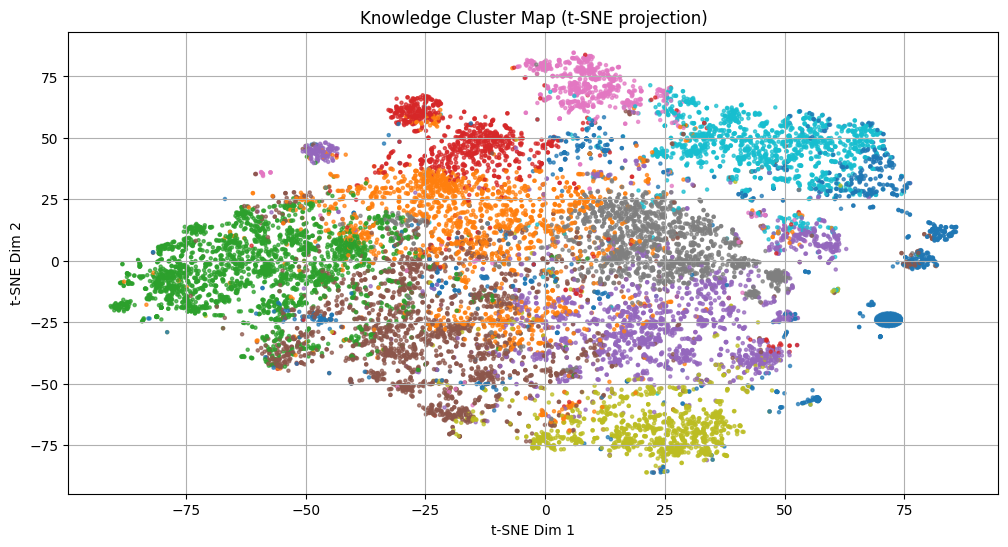

In [3]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load all vectors from FAISS
X = np.stack([index.reconstruct(i) for i in range(index.ntotal)])

# Project to 2D
print("Running t-SNE...")
X_2d = TSNE(n_components=2, perplexity=50, init='pca', random_state=42).fit_transform(X)

# Cluster into k groups (can tune this number)
k = 10
print(f"Running k-means with k={k}...")
km = KMeans(n_clusters=k, random_state=42).fit(X)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=km.labels_, cmap='tab10', s=5, alpha=0.7)
plt.title("Knowledge Cluster Map (t-SNE projection)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.show()


In [4]:
from sentence_transformers import SentenceTransformer
import faiss

# Load the same model as your embedding pipeline
encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Define test queries
queries = [
    "What is order flow imbalance?",
    "Explain the Kelly criterion.",
    "What causes slippage in trade execution?",
    "What is market microstructure?",
    "Define adverse selection in trading.",
]

# Top-k neighbors to retrieve
k = 3

# Run semantic search
for q in queries:
    print("="*120)
    print(f"üîç Query: {q}")
    q_embed = encoder.encode([q])
    D, I = index.search(q_embed, k)

    for i, idx in enumerate(I[0]):
        row = meta.iloc[idx]
        print(f"\n‚Üí Result {i+1} (score: {D[0][i]:.4f}):")
        print("-"*100)
        print(f"[Source: {row.get('source', 'N/A')} | Page: {row.get('page', 'N/A')}]")
        print(row.get("text_preview", "[No content]"))


/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


üîç Query: What is order flow imbalance?

‚Üí Result 1 (score: 0.5559):
----------------------------------------------------------------------------------------------------
[Source: Order-Flow-Trading-Setups-1.pdf | Page: 92]
35 Imbalances Imbalances are a great way of tracking market sentiment. Only with Order Flow will you...

‚Üí Result 2 (score: 0.6034):
----------------------------------------------------------------------------------------------------
[Source: Pairs trading quantitative methods and analysis.pdf | Page: 8]
30 contemporaneous imbalance and four lags of order imbalance were used as explanatory variable. The...

‚Üí Result 3 (score: 0.6886):
----------------------------------------------------------------------------------------------------
[Source: Pairs trading quantitative methods and analysis.pdf | Page: 7]
29 2.4 Orderflow Imbalance The limit order book contains all the information available to investigat...
üîç Query: Explain the Kelly criterion.

‚Üí Result 

In [5]:
from sklearn.metrics import pairwise_distances_argmin_min
import pandas as pd

# Number of clusters
k = 10

# Re-run k-means to get centroids (if needed)
km = KMeans(n_clusters=k, random_state=42).fit(X)

# Find medoid of each cluster (closest chunk to cluster center)
medoid_idxs, _ = pairwise_distances_argmin_min(km.cluster_centers_, X)

# Print results
cluster_labels = {}

for i, medoid_idx in enumerate(medoid_idxs):
    row = meta.iloc[medoid_idx]
    text = row.get("text_preview", "[No preview]")
    source = row.get("source", "Unknown")
    page = row.get("page", "?")

    print("="*100)
    print(f"üß† Cluster {i} ‚Äî Suggested Medoid (chunk #{medoid_idx})")
    print(f"[Source: {source} | Page: {page}]")
    print(f"Preview: {text[:500]}...\n")

    # Optional: manually name it now
    cluster_labels[i] = f"Cluster {i} ‚Äî [Name me based on above]"



üß† Cluster 0 ‚Äî Suggested Medoid (chunk #5052)
[Source: Mastering Bitcoin antonopoulos.pdf | Page: 48]
Preview: B. Transaction Script Language Operators, Constants, and Symbols. . . . . . . . . . . . . . . . . 31......

üß† Cluster 1 ‚Äî Suggested Medoid (chunk #2458)
[Source: edwards-magee-technical-analysis-of-stock-trends-9th-edition.pdf | Page: 392]
Preview: 324 Technical Analysis of Stock Trends losses. (Small losses you will have to take, and as quickly a......

üß† Cluster 2 ‚Äî Suggested Medoid (chunk #12267)
[Source: Thomas N. Bulkowski-Encyclopedia Of Chart Patterns.pdf | Page: 503]
Preview: below 30.38. At its lowest point, it closes at 29.88. That is just fifty cents below the low, but it......

üß† Cluster 3 ‚Äî Suggested Medoid (chunk #11559)
[Source: the-man-who-solved-the-market-how-jim-simons-launched-the-quant-revolution-hardcovernbsped-073521798x-9780735217980.pdf | Page: 323]
Preview: theorist, Simons built a computer model capable of digesting torrents of dat

In [6]:
cluster_labels = {
    0: "Crypto Protocols & Architecture",
    1: "Technical Analysis ‚Äì Risk Framing",
    2: "Chart Patterns & Price Extremes",
    3: "Quantitative Finance & Simons",
    4: "Options Pricing & Volatility Math",
    5: "Technical Indicators ‚Äì Reliability",
    6: "Macro Risk Management",
    7: "Market Liquidity & Order Flow",
    8: "ML/Stats in Quant Models",
    9: "Crypto Market Structure & Risks",
}

# Save to CSV for inspection or further mapping
meta["cluster_id"] = km.labels_
meta["cluster_label"] = meta["cluster_id"].map(cluster_labels)
meta.to_csv(DATA_DIR / "metadata_with_clusters.csv", index=False)


In [7]:
import pandas as pd

# Your full concept list (shortened version shown here)
concepts = [
     # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 1. Market Microstructure ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    "limit order book",
    "market depth",
    "order book imbalance",
    "order matching engine",
    "price discovery",
    "bid-ask spread",
    "tick size",
    "quote stuffing",
    "market impact",
    "adverse selection",
    "hidden liquidity",
    "latency arbitrage",
    "maker-taker fees",
    "high-frequency trading",
    "flash crash dynamics",
    "order book spoofing",
    "fill probability",
    "queue position",
    "liquidity fragmentation",
    "trading halts",
    "short-term auction effects",

    # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 2. Order Flow & Execution ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    "execution algorithms",
    "TWAP",
    "VWAP",
    "implementation shortfall",
    "slippage",
    "smart order routing",
    "parent/child order logic",
    "iceberg orders",
    "passive vs aggressive order flow",
    "cancel-replace ratio",
    "execution latency",
    "fill ratio",
    "trade execution certainty",
    "trade sequencing",
    "order flow imbalance",
    "quote-to-trade ratio",
    "multi-leg order routing",

    # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 3. Technical & Quant Analysis ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    "moving average crossover",
    "relative strength index",
    "macd",
    "bollinger bands",
    "fibonacci retracement",
    "volume profile",
    "trendlines",
    "candlestick reversal patterns",
    "momentum divergence",
    "price action",
    "trend following",
    "mean reversion",
    "chart pattern recognition",
    "indicator lag",
    "supply and demand zones",
    "volume weighted indicators",
    "fractals in price data",

    # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 4. Portfolio & Risk Management ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    "value at risk",
    "conditional value at risk",
    "maximum drawdown",
    "risk-adjusted return",
    "sharpe ratio",
    "sortino ratio",
    "omega ratio",
    "tail risk",
    "liquidity risk",
    "credit risk",
    "counterparty risk",
    "position sizing",
    "kelly criterion",
    "exposure management",
    "stress testing",
    "scenario analysis",
    "margin risk",
    "portfolio volatility",
    "correlation matrix",
    "beta exposure",
    "concentration risk",
    "regulatory capital",
    "drawdown control",
    "trading halts and kill switches",
    "value decay over drawdowns",
    "stop loss engineering",

    # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 5. Psychology & Behavioral Risk ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    "loss aversion",
    "confirmation bias",
    "recency bias",
    "overconfidence bias",
    "anchoring bias",
    "emotional trading",
    "overtrading",
    "revenge trading",
    "fear and greed cycles",
    "trader discipline",
    "decision fatigue",
    "mental stop loss",
    "self-sabotage in trading",
    "cognitive dissonance",
    "regret minimization",
    "risk appetite profiling",

    # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 6. Crypto Market Structure ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    "on-chain liquidity",
    "cex vs dex",
    "impermanent loss",
    "oracle latency",
    "stablecoin depegging risk",
    "MEV (maximal extractable value)",
    "rug pull",
    "slashing risk",
    "smart contract risk",
    "liquidity mining",
    "staking derivatives",
    "yield farming",
    "token vesting cliffs",
    "governance attacks",
    "cross-chain bridge risk",
    "custody vs self custody",
    "flash loan attacks",
    "TVL manipulation",
    "gas fee volatility",
    "proof of reserves",
    "validator concentration risk",
    "exchange insolvency risk",

    # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 7. Macroeconomics & Liquidity ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    "interest rate risk",
    "yield curve inversion",
    "inflation targeting",
    "quantitative tightening",
    "quantitative easing",
    "federal funds rate",
    "liquidity trap",
    "repo operations",
    "reverse repo facility",
    "dollar liquidity cycles",
    "cross-currency basis swap",
    "USD collateral tightening",
    "global risk-on risk-off",
    "monetary policy divergence",
    "macro liquidity regime shifts",
    "CB balance sheet expansion",
    "eurodollar system",
    "shadow banking system",
    "global USD shortage",

    # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 8. Machine Learning & Modeling ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    "overfitting",
    "cross-validation",
    "feature importance",
    "hyperparameter tuning",
    "gradient boosting trees",
    "long short-term memory networks",
    "temporal convolutional networks",
    "transformer models for trading",
    "walk forward validation",
    "sliding window retraining",
    "online learning",
    "non-stationary time series",
    "target leakage",
    "ensemble methods",
    "reinforcement learning for trade execution",
    "meta-labeling",
    "probabilistic confidence calibration",
    "covariate shift detection",
    "signal decay tracking",

    # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 9. Derivatives & Options ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    "option greeks",
    "gamma exposure",
    "delta hedging",
    "theta decay",
    "vega compression",
    "skew arbitrage",
    "implied vs realized volatility",
    "volatility surface modeling",
    "straddle",
    "strangle",
    "covered call",
    "iron condor",
    "volatility term structure",
    "option open interest dynamics",
    "tail hedging",
    "volatility crush",
    "synthetic replication",
    "OTM skew behavior",

    # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 10. Regulation, Fraud, Infrastructure Risk ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    "insider trading",
    "wash trading",
    "pump and dump",
    "front-running bots",
    "exchange outage risk",
    "flash crash regulation",
    "spoofing and layering",
    "market manipulation",
    "dark pool reporting rules",
    "KYC AML enforcement",
    "regulatory arbitrage",
    "jurisdictional risk",
    "market surveillance",
    "algo trading compliance",
    "post-trade transparency",
    "circuit breaker logic",

    # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ 11. Meta-Reasoning, Evaluation & Agent Tools ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    "reasoning under uncertainty",
    "meta-cognition in strategy switching",
    "confidence scoring",
    "backtest overfitting detection",
    "real vs simulated performance tracking",
    "regime detection",
    "behavioral edge extraction",
    "reward shaping for AI agents",
    "agent burn-in period",
    "decision tree vs ensemble path tracing",
    "multi-agent coordination risk",
    "agent self-correction heuristics"
]

# Convert the list into a DataFrame (like a spreadsheet in memory)
concepts_df = pd.DataFrame({"concept": concepts})

# Save that DataFrame to a .csv file in your /workspace/data folder
concepts_df.to_csv(DATA_DIR / "concept_list.csv", index=False)

print("‚úÖ Your concept list has been saved to /workspace/data/concept_list.csv")


‚úÖ Your concept list has been saved to /workspace/data/concept_list.csv


In [8]:
import os
print(os.listdir(DATA_DIR))


['.ipynb_checkpoints', 'concepts_missing_or_weak.csv', 'concept_coverage_0p65.csv', 'concept_coverage_priority_first.csv', 'concept_coverage_results.csv', 'concept_list.csv', 'embedding_validation_results_direct.csv', 'faiss_chunks_metadata_direct.csv', 'faiss_direct.index', 'faiss_stats.json', 'metadata_with_clusters.csv', 'priority_faiss.index', 'priority_metadata.csv', 'qa_tasks.jsonl', 'questions']


In [9]:
concepts_df = pd.read_csv(DATA_DIR / "concept_list.csv")
print(concepts_df.head())
print(f"‚úÖ Loaded {len(concepts_df)} concepts from CSV")


                 concept
0       limit order book
1           market depth
2   order book imbalance
3  order matching engine
4        price discovery
‚úÖ Loaded 203 concepts from CSV


In [10]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

# Load concept list from the saved CSV
concepts_df = pd.read_csv(DATA_DIR / "concept_list.csv")
concepts = concepts_df["concept"].tolist()

# Load the encoder model (same as used in embeddings)
encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Parameters
threshold = 0.55  # Lower = stricter match
coverage = []

print(f"üîç Running coverage check on {len(concepts)} concepts...")

for concept in concepts:
    q_embed = encoder.encode([concept])
    D, I = index.search(q_embed, 1)
    dist = D[0][0]
    idx = I[0][0]
    row = meta.iloc[idx]

    is_covered = dist <= threshold
    coverage.append({
        "concept": concept,
        "covered": is_covered,
        "distance": dist,
        "best_chunk": row.get("text_preview", "[No preview]"),
        "source": row.get("source", "Unknown"),
        "page": row.get("page", "?")
    })

# Save results to CSV
coverage_df = pd.DataFrame(coverage)
coverage_df.to_csv(DATA_DIR / "concept_coverage_results.csv", index=False)

# Show top 10 best matches
print("‚úÖ Coverage check complete. Showing top 10 strongest matches:\n")
coverage_df.sort_values("distance").head(10)


üîç Running coverage check on 203 concepts...
‚úÖ Coverage check complete. Showing top 10 strongest matches:



concept  covered      distance  \
13          high-frequency trading     True  1.882928e-13   
50       chart pattern recognition     True  4.658612e-01   
86               emotional trading     True  5.013845e-01   
9                adverse selection     True  5.269598e-01   
175                insider trading     True  5.289318e-01   
63                  liquidity risk    False  5.504458e-01   
45   candlestick reversal patterns    False  5.604916e-01   
90               trader discipline    False  5.773262e-01   
64                     credit risk    False  5.809343e-01   
43                  volume profile    False  5.846533e-01   

                                            best_chunk  \
13                           High-Frequency Trading...   
50                   Encyclopedia of Chart Patterns...   
86   358 THE INDIVIDUAL, SELF-DIRECTED TRADER our p...   
9    Average daily number of trades ‚Äî The higher it...   
175  Professor Larry Harris Trading and Exchanges D...   
63   Liquidity Risk 523 Bangia, A., F. Diebold, T. ...   
45   79 CANdLESTICkS A close‚Äêup of the same chart, ...   
90   398 THE INDIVIDUAL, SELF-DIRECTED TRADER psych...   
64                            PART Four Credit Risk...   
43   121 What Does Volume Profile Look Like? Volume...   

                                                source  page  
13                    high frequency trading Irene.pdf    29  
50   Thomas N. Bulkowski-Encyclopedia Of Chart Patt...   473  
86   pcmbrokers_(Wiley finance series) Adam Grimes-...   431  
9                 Mark_Douglas_Trading_in_the_Zone.pdf     9  
175                            TradingOrderFlow768.pdf     2  
63      risk management and financial institutions.pdf   635  
45   Breakthrough_Strategies_for_Predicting_Any_Mar...   104  
90   pcmbrokers_(Wiley finance series) Adam Grimes-...   472  
64      risk management and financial institutions.pdf   493  
43   orderflow trading and high frequency trading p...     5

In [11]:
# Show all concepts not confidently covered
missing_df = coverage_df[coverage_df["covered"] == False].sort_values("distance")
missing_df.to_csv(DATA_DIR / "concepts_missing_or_weak.csv", index=False)

print("üìÑ Exported missing/weak concepts to 'concepts_missing_or_weak.csv'")
missing_df.head(10)


üìÑ Exported missing/weak concepts to 'concepts_missing_or_weak.csv'


concept  covered  distance  \
63                  liquidity risk    False  0.550446   
45   candlestick reversal patterns    False  0.560492   
90               trader discipline    False  0.577326   
64                     credit risk    False  0.580934   
43                  volume profile    False  0.584653   
142        gradient boosting trees    False  0.595171   
185           regulatory arbitrage    False  0.599279   
140             feature importance    False  0.602450   
65               counterparty risk    False  0.604365   
0                 limit order book    False  0.612864   

                                            best_chunk  \
63   Liquidity Risk 523 Bangia, A., F. Diebold, T. ...   
45   79 CANdLESTICkS A close‚Äêup of the same chart, ...   
90   398 THE INDIVIDUAL, SELF-DIRECTED TRADER psych...   
64                            PART Four Credit Risk...   
43   121 What Does Volume Profile Look Like? Volume...   
142  10.2 Boosting Fits an Additive Model 341 very ...   
185                           Statistical Arbitrage...   
140  114 FEATURE IMPORTANCE natural question is to ...   
65   Counterparty Risk Counterparty risk is the ris...   
0    85 Example #5: Big Limit Orders Example #6: Bi...   

                                                source  page  
63      risk management and financial institutions.pdf   635  
45   Breakthrough_Strategies_for_Predicting_Any_Mar...   104  
90   pcmbrokers_(Wiley finance series) Adam Grimes-...   472  
64      risk management and financial institutions.pdf   493  
43   orderflow trading and high frequency trading p...     5  
142           The Elements of Statistical Learning.pdf   533  
185       STATISTICAL_CONSEQUENCES_OF_FAT_TAILS_TE.pdf    63  
140  Marcos Lopez de Prado - Advances in Financial ...   170  
65                              mastering-ethereum.pdf   463  
0                      Order-Flow-Trading-Setups-1.pdf   142

In [12]:
from pathlib import Path
DATA_DIR = Path("/workspace/data/embeddings")   # same path you used earlier


In [ ]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
#  High‚ÄëResolution Re‚ÄëEmbedding of Priority PDFs
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
from pathlib import Path
import os, hashlib
import fitz                               # PyMuPDF
import pandas as pd
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer

# ----- paths -----
# main embeddings folder (same as earlier)
DATA_DIR = Path("/workspace/data/embeddings")
# folder where the uploaded PDFs live
priority_dir = Path("/workspace/priority_pdfs")

# ----- discover all PDFs automatically -----
pdf_files = sorted([p for p in priority_dir.glob("*.pdf")])
print("üìö PDFs found for re‚Äëembedding:")
for p in pdf_files:
    print("  ‚Ä¢", p.name)

# ----- parameters -----
chunk_size = 350        # smaller chunks = higher resolution
model      = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
vectors    = []
metadata   = []

# ----- process each PDF -----
for pdf_path in pdf_files:
    doc = fitz.open(pdf_path)
    print(f"\nüìñ Processing: {pdf_path.name} ({len(doc)} pages)")

    for page_num in range(len(doc)):
        text = doc[page_num].get_text()
        if not text or len(text) < 50:
            continue

        # chunk the page text
        for i in range(0, len(text), chunk_size):
            chunk = text[i : i + chunk_size].strip()
            if len(chunk) < 100:
                continue

            vec = model.encode(chunk).astype(np.float32)
            vectors.append(vec)

            metadata.append({
                "chunk_id"      : hashlib.sha256(chunk.encode()).hexdigest(),
                "text_preview"  : chunk[:400],
                "source"        : pdf_path.name,
                "page"          : page_num + 1,
                "is_priority"   : True
            })

# ----- build & save FAISS index -----
if not vectors:
    raise ValueError("No valid chunks extracted. Check PDF contents.")

dimension = len(vectors[0])
index     = faiss.IndexFlatL2(dimension)
index.add(np.vstack(vectors))

faiss_path      = DATA_DIR / "priority_faiss.index"
metadata_path   = DATA_DIR / "priority_metadata.csv"

faiss.write_index(index, str(faiss_path))
pd.DataFrame(metadata).to_csv(metadata_path, index=False)

print("\n‚úÖ High‚Äëresolution index & metadata saved:")
print("   ‚Ä¢", faiss_path)
print("   ‚Ä¢", metadata_path)
print("   ‚Ä¢ Chunks embedded:", len(vectors))



In [14]:
from sentence_transformers import SentenceTransformer
import faiss, pandas as pd

encoder         = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
main_index      = faiss.read_index(str(DATA_DIR / "faiss_direct.index"))
priority_index  = faiss.read_index(str(DATA_DIR / "priority_faiss.index"))

meta_main       = pd.read_csv(DATA_DIR / "faiss_chunks_metadata_direct.csv")
meta_priority   = pd.read_csv(DATA_DIR / "priority_metadata.csv")


In [15]:
def semantic_search(query, k=5, boost=0.10):
    q_vec = encoder.encode([query])
    
    # 1) priority search
    Dp, Ip = priority_index.search(q_vec, k)
    results = []
    for d, i in zip(Dp[0], Ip[0]):
        score = (1 - d) + boost           # give priority chunks extra weight
        row   = meta_priority.iloc[i]
        results.append(("priority", score, row))
    
    # 2) main search (fill remaining slots)
    if len(results) < k:
        Dm, Im = main_index.search(q_vec, k - len(results))
        for d, i in zip(Dm[0], Im[0]):
            score = (1 - d)               # normal score
            row   = meta_main.iloc[i]
            results.append(("main", score, row))
    
    # sort by final score descending
    results.sort(key=lambda x: -x[1])
    return results[:k]


In [16]:
hits = semantic_search("explain liquidity risk", k=5, boost=0.10)

for src, score, row in hits:
    print(f"[{src}] {score:.3f} | {row['source']} p.{row['page']}")
    print("   ", row['text_preview'][:140], "...\n")


[priority] 0.769 | Counterparty Credit Risk- The new challenge for global -- Jon Gregory -- The Wiley Finance Series, 1, 2010 -- John Wiley & Sons, Incorporated.pdf p.28
    liquidity risk represents the
risk that a transaction cannot be executed at market prices, perhaps due to the size of the
position and/or re ...

[priority] 0.736 | The xVA Challenge- Counterparty Credit Risk, Funding, -- Jon Gregory -- The Wiley Finance Series, 3rd Edition 2015, 2015 -- Wiley & Sons, Limited.pdf p.47
    3.2.4 Liquidity risk
Liquidity risk is normally characterised in two forms. Asset liquidity risk represents the 
risk that a transaction can ...

[priority] 0.617 | Counterparty Credit Risk- The new challenge for global -- Jon Gregory -- The Wiley Finance Series, 1, 2010 -- John Wiley & Sons, Incorporated.pdf p.151
    . Liquidation risk. The risk that by liquidating an amount of a security that is large
compared with the volume traded in that security, the ...

[priority] 0.589 | The structure of

In [17]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
#  Priority‚ÄëFirst Concept Coverage Scan
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
from sentence_transformers import SentenceTransformer
import pandas as pd
import faiss, numpy as np

# 1.  Load concept list
concepts     = pd.read_csv(DATA_DIR / "concept_list.csv")["concept"].tolist()

# 2.  Load indices & metadata
encoder         = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
priority_index  = faiss.read_index(str(DATA_DIR / "priority_faiss.index"))
main_index      = faiss.read_index(str(DATA_DIR / "faiss_direct.index"))
meta_priority   = pd.read_csv(DATA_DIR / "priority_metadata.csv")
meta_main       = pd.read_csv(DATA_DIR / "faiss_chunks_metadata_direct.csv")

def hybrid_search(vec, k=1, boost=0.10):
    # priority first
    Dp, Ip = priority_index.search(vec, k)
    best_d, best_i, best_src = Dp[0][0], Ip[0][0], "priority"
    best_score = (1 - best_d) + boost
    
    # main fallback
    Dm, Im = main_index.search(vec, 1)
    alt_d, alt_i = Dm[0][0], Im[0][0]
    alt_score    = (1 - alt_d)
    
    # choose highest score
    if alt_score > best_score:
        return "main", alt_d, alt_i
    else:
        return best_src, best_d, best_i

results = []
threshold = 0.65   # keep same threshold

for concept in concepts:
    q_vec = encoder.encode([concept])
    src, dist, idx = hybrid_search(q_vec, k=1, boost=0.10)
    
    row = meta_priority.iloc[idx] if src == "priority" else meta_main.iloc[idx]
    covered = dist <= threshold
    
    results.append({
        "concept"   : concept,
        "covered"   : covered,
        "distance"  : dist,
        "source"    : row["source"],
        "page"      : row["page"],
        "priority?" : src == "priority"
    })

coverage_df = pd.DataFrame(results)
coverage_df.to_csv(DATA_DIR / "concept_coverage_priority_first.csv", index=False)

print("‚úÖ Scan complete.  Missing / weak concepts:")
missing = coverage_df[coverage_df["covered"] == False].sort_values("distance")
display(missing.head(20))


‚úÖ Scan complete.  Missing / weak concepts:


concept  covered  distance  \
47                 price action    False  0.652456   
71                  margin risk    False  0.655575   
70            scenario analysis    False  0.658626   
159               delta hedging    False  0.667127   
130   USD collateral tightening    False  0.668989   
181       spoofing and layering    False  0.670691   
149  non-stationary time series    False  0.673820   
162              skew arbitrage    False  0.673943   
49               mean reversion    False  0.674243   
169   volatility term structure    False  0.678252   
33    trade execution certainty    False  0.678447   
187         market surveillance    False  0.680591   
72         portfolio volatility    False  0.681627   
10             hidden liquidity    False  0.682524   
23                         VWAP    False  0.685065   
19                trading halts    False  0.689157   
89        fear and greed cycles    False  0.689969   
59                 sharpe ratio    False  0.692804   
188     algo trading compliance    False  0.698513   
141       hyperparameter tuning    False  0.700681   

                                                source  page  priority?  
47   The Art and Science of Technical Analysis- Mar...    36       True  
71      risk management and financial institutions.pdf   412       True  
70      risk management and financial institutions.pdf   516       True  
159     risk management and financial institutions.pdf   200       True  
130  The xVA Challenge- Counterparty Credit Risk, F...   130       True  
181                             gpt deep dive gaps.pdf    91       True  
149  Advances in Financial Machine Learning by LoÃÅp...   103       True  
162       STATISTICAL_CONSEQUENCES_OF_FAT_TAILS_TE.pdf    63      False  
49                                meanreversionins.pdf    35      False  
169     risk management and financial institutions.pdf   252       True  
33   The Financial Mathematics of Market Liquidity-...   299       True  
187                             gpt deep dive gaps.pdf    92       True  
72                                             Unknown     0      False  
10   The structure of clearing and settlement -- Da...   191       True  
23   Optimal trading strategies - quantitative appr...   297       True  
19                              gpt deep dive gaps.pdf    34       True  
89   Trading in the Zone - Master the Market with C...    56       True  
59   Advances in Financial Machine Learning by LoÃÅp...    19       True  
188                             gpt deep dive gaps.pdf    95       True  
141  Advances in Financial Machine Learning by LoÃÅp...   156       True

In [18]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Incremental re‚Äëembed of priority_pdfs ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
from pathlib import Path
import fitz, hashlib, faiss, numpy as np, pandas as pd
from sentence_transformers import SentenceTransformer

# 1. Paths
DATA_DIR      = Path("/workspace/data/embeddings")          # main data folder
priority_dir  = Path("/workspace/priority_pdfs")            # folder with PDFs
index_path    = DATA_DIR / "priority_faiss.index"
meta_path     = DATA_DIR / "priority_metadata.csv"

# 2. Load existing index & metadata (if present)
if index_path.exists():
    priority_index = faiss.read_index(str(index_path))
    meta_df        = pd.read_csv(meta_path)
    existing_sha   = set(meta_df["chunk_id"])
    print(f"üìö Existing chunks: {len(meta_df)}")
else:
    priority_index = None
    meta_df        = pd.DataFrame()
    existing_sha   = set()
    print("üìö No existing priority index found ‚Äì fresh start.")

# 3. Parameters
chunk_size = 350
model      = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# 4. Walk through PDFs and collect NEW chunks
vectors, new_meta = [], []
for pdf_path in priority_dir.glob("*.pdf"):
    doc = fitz.open(pdf_path)
    print(f"üîç Scanning {pdf_path.name} ({len(doc)} pages)")

    for page_num in range(len(doc)):
        text = doc[page_num].get_text("text")
        if not text: 
            continue
        for i in range(0, len(text), chunk_size):
            chunk = text[i:i+chunk_size].strip()
            if len(chunk) < 100:             # skip tiny fragments
                continue
            sha = hashlib.sha256(chunk.encode()).hexdigest()
            if sha in existing_sha:          # already embedded
                continue
            vectors.append(model.encode(chunk).astype(np.float32))
            new_meta.append({
                "chunk_id"     : sha,
                "text_preview" : chunk[:400],
                "source"       : pdf_path.name,
                "page"         : page_num + 1,
                "is_priority"  : True
            })

# 5. Add new vectors to FAISS and save
if vectors:
    vecs_np = np.vstack(vectors)
    if priority_index is None:                      # first‚Äëtime build
        priority_index = faiss.IndexFlatL2(vecs_np.shape[1])
    priority_index.add(vecs_np)

    faiss.write_index(priority_index, str(index_path))
    meta_df = pd.concat([meta_df, pd.DataFrame(new_meta)], ignore_index=True)
    meta_df.to_csv(meta_path, index=False)

    print(f"\n‚úÖ Added {len(vectors)} new chunks "
          f"from {len(set(m['source'] for m in new_meta))} new PDF(s).")
    print("   Total priority chunks:", len(meta_df))
else:
    print("\n‚úÖ No new chunks detected. Priority index already up‚Äëto‚Äëdate.")


ModuleNotFoundError: No module named 'fitz'

In [ ]:
# --- reload fresh metadata to match indices ---
meta_priority = pd.read_csv(DATA_DIR / "priority_metadata.csv")
meta_main     = pd.read_csv(DATA_DIR / "faiss_chunks_metadata_direct.csv")

assert priority_index.ntotal == len(meta_priority), \
       f"Priority index rows ({priority_index.ntotal}) ‚â† metadata rows ({len(meta_priority)})"

assert main_index.ntotal == len(meta_main), \
       f"Main index rows ({main_index.ntotal}) ‚â† metadata rows ({len(meta_main)})"


In [ ]:
# --- Coverage re‚Äëscan (threshold = 0.65) -----------------------------
from sentence_transformers import SentenceTransformer
import pandas as pd, faiss, numpy as np

encoder   = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
threshold = 0.65

concepts = pd.read_csv(DATA_DIR / "concept_list.csv")["concept"].tolist()

coverage  = []
for concept in concepts:
    q_vec = encoder.encode([concept])

    # ---- search priority first
    Dp, Ip = priority_index.search(q_vec, 1)
    best_dist   = Dp[0][0]
    best_row    = meta_priority.iloc[Ip[0][0]]
    is_prior    = True

    # ---- search main, take if closer
    Dm, Im = main_index.search(q_vec, 1)
    if Dm[0][0] < best_dist:
        best_dist = Dm[0][0]
        best_row  = meta_main.iloc[Im[0][0]]
        is_prior  = False

    coverage.append({
        "concept"    : concept,
        "covered"    : best_dist <= threshold,
        "distance"   : best_dist,
        "source"     : best_row["source"],
        "page"       : best_row["page"],
        "priority?"  : is_prior
    })

coverage_df = pd.DataFrame(coverage)
coverage_df.to_csv(DATA_DIR / "concept_coverage_0p65.csv", index=False)

print("‚úÖ Scan complete.  Missing / weak concepts:")
display(coverage_df[~coverage_df["covered"]].sort_values("distance").head(20))
